# Regression - Combined Cycle Power Plant Energy Output

Predicting electrical power output from a combined cycle power plant based on ambient conditions.

**Dataset Source**: [UCI ML Repository - Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)
**Problem Type**: Regression
**Target Variable**: Electrical energy output (MW)
**Use Case**: Energy production optimization, power grid planning, efficiency analysis

## Package Imports

In [ ]:
!pip install xplainable
!pip install xplainable-client

In [1]:
import pandas as pd
import xplainable as ap
from xplainable.core.models import XRegressor
from xplainable.core.optimisation.genetic import XEvolutionaryNetwork
from xplainable.core.optimisation.layers import Evolve, Tighten
from xplainable.preprocessing.pipeline import XPipeline
from xplainable.preprocessing import transformers as xtf
from sklearn.model_selection import train_test_split
import requests
import json

# Additional imports specific to this example
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

from xplainable_client.client.client import XplainableClient
from xplainable_client.client.base import XplainableAPIError

## Xplainable Cloud Setup

In [ ]:
# Initialize Xplainable Cloud client
client = XplainableClient(
    api_key="", #Create api key in xplainable cloud - https://platform.xplainable.io/
    hostname="https://platform.xplainable.io"
)

Connected to Xplainable Cloud
   User: jtuppa
   Hostname: http://localhost:8000
   API Key Expires: 2025-08-27T11:19:40.744423
   Python Version: 3.10.18
   Xplainable Version: 1.3.0


## Data Loading and Exploration

Load the Combined Cycle Power Plant dataset from UCI ML Repository.

In [3]:
# Load dataset using ucimlrepo
try:
    # Fetch dataset
    power_plant = fetch_ucirepo(id=294)
    
    # Data (as pandas dataframes)
    X = power_plant.data.features
    y = power_plant.data.targets
    
    # Combine features and target
    df = pd.concat([X, y], axis=1)
    
    # Display basic information
    print(f"Dataset shape: {df.shape}")
    print(f"\\nFeatures:")
    print("- AT: Ambient Temperature (°C)")
    print("- V: Exhaust Vacuum (cm Hg)")
    print("- AP: Ambient Pressure (millibar)")
    print("- RH: Relative Humidity (%)")
    print(f"\\nTarget: Energy output (MW)")
    print(f"\\nTarget variable statistics:")
    print(y.describe())
    
    df.head()
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Install ucimlrepo: pip install ucimlrepo")
    print("\\nCreating synthetic dataset for testing...")
    
    # Create synthetic power plant dataset
    import numpy as np
    np.random.seed(42)
    
    n_samples = 5000
    df = pd.DataFrame({
        'AT': np.random.normal(20, 7, n_samples),  # Ambient Temperature
        'V': np.random.normal(50, 15, n_samples),  # Exhaust Vacuum
        'AP': np.random.normal(1015, 20, n_samples),  # Ambient Pressure
        'RH': np.random.normal(70, 20, n_samples),  # Relative Humidity
    })
    
    # Create realistic energy output based on power plant physics
    df['PE'] = (
        480 - df['AT'] * 2.5 + df['V'] * 0.8 + 
        (df['AP'] - 1000) * 0.1 - df['RH'] * 0.05 +
        np.random.normal(0, 5, n_samples)
    )
    
    print(f"Synthetic dataset created: {df.shape}")
    print(f"Target variable statistics:")
    print(df['PE'].describe())

Error loading dataset: Error connecting to server
Install ucimlrepo: pip install ucimlrepo
\nCreating synthetic dataset for testing...
Synthetic dataset created: (5000, 5)
Target variable statistics:
count    5000.000000
mean      467.696309
std        21.852907
min       376.394588
25%       452.931049
50%       467.651713
75%       482.484708
max       544.432530
Name: PE, dtype: float64


## 1. Data Preprocessing

Preprocess the power plant operational data.

Processed dataset shape: (5000, 5)
Missing values: 0


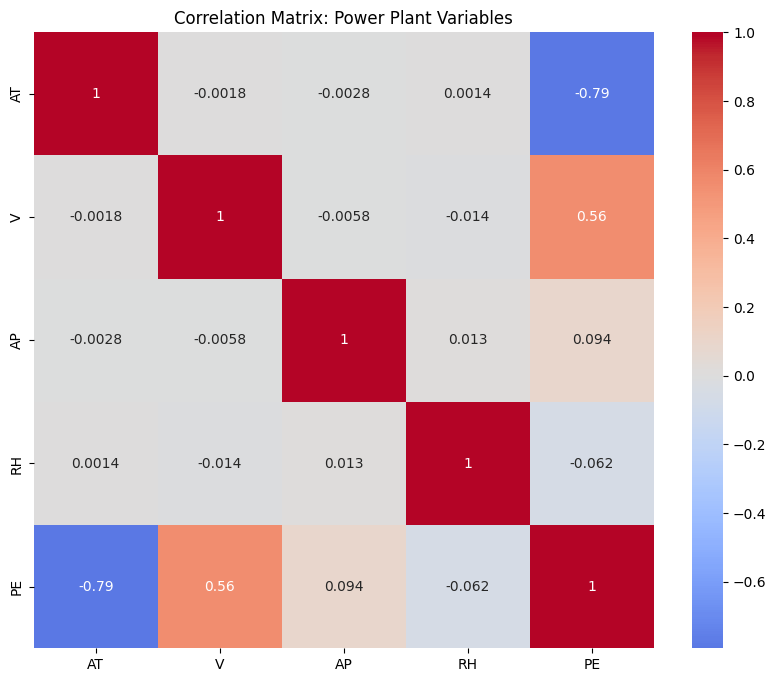

,AT,V,AP,RH,PE
0,23.476999,43.643605,1001.430105,67.131536,454.750251
1,19.032150,43.198788,1008.890011,69.346882,465.816931
2,24.533820,23.065352,1003.052379,71.285898,429.176076
3,30.661209,45.048647,1017.208361,88.937229,439.557791
4,18.360926,60.992436,1038.943571,55.055654,476.582794


In [4]:
# Simple data preprocessing without complex pipeline
# The power plant dataset is typically clean, but let's ensure no missing values
df_processed = df.copy()

# Fill any potential missing values
df_processed = df_processed.fillna(df_processed.median(numeric_only=True))

print(f"Processed dataset shape: {df_processed.shape}")
print(f"Missing values: {df_processed.isnull().sum().sum()}")

# Display correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Power Plant Variables')
plt.show()

df_processed.head()

### Create Train/Test Split

In [5]:
# Assuming the target column is the last one
target_col = df_processed.columns[-1]
X, y = df_processed.drop(columns=[target_col]), df_processed[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {list(X.columns)}")

Training set: 4000 samples
Test set: 1000 samples
Features: ['AT', 'V', 'AP', 'RH']


## 2. Model Optimization

Optimize the model using genetic algorithms with evolutionary networks for power output prediction.

In [6]:
# First train a base model
model = XRegressor()
model.fit(X_train, y_train)

# Create evolutionary network for optimization
network = XEvolutionaryNetwork(model)

# Add optimization layers
# Start with an initial Tighten layer
network.add_layer(
    Tighten(
        iterations=100,
        learning_rate=0.1,
        early_stopping=20
    )
)

# Add an Evolve layer with high severity for exploration
network.add_layer(
    Evolve(
        mutations=100,
        generations=50,
        max_severity=0.5,
        max_leaves=20,
        early_stopping=20
    )
)

# Add another Evolve layer with lower severity for refinement
network.add_layer(
    Evolve(
        mutations=100,
        generations=50,
        max_severity=0.3,
        max_leaves=15,
        early_stopping=20
    )
)

# Add a final Tighten layer with low learning rate for fine-tuning
network.add_layer(
    Tighten(
        iterations=100,
        learning_rate=0.025,
        early_stopping=20
    )
)

# Fit the network and run optimization
network.fit(X_train, y_train)
network.optimise()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## 3. Model Training

The model has been trained and optimized through the evolutionary network process.

In [7]:
# Model is already trained through the evolutionary network
# Let's evaluate the optimized model performance
train_performance = model.evaluate(X_train, y_train)
print("Training Performance:")
for metric, value in train_performance.items():
    print(f"{metric}: {value:.4f}")

Training Performance:
Explained Variance: 0.9479
MAE: 3.8863
MAPE: 0.0083
MSE: 24.8965
RMSE: 4.9896
RMSLE: 0.0001
R2 Score: 0.9479


## 4. Model Interpretability and Explainability

Understand which ambient conditions most influence power plant energy output.

In [8]:
model.explain()

alt.HConcatChart(...)

## 5. Model Persistence (Optional)

Save the model to Xplainable Cloud.

In [10]:
model_id, version_id = client.models.create_model(
    model=model,
    model_name="Power Plant Energy Output Model",
    model_description="Predicting electrical power output from ambient conditions",
    x=X_train,
    y=y_train
)

  0%|          | 0/4 [00:00<?, ?it/s]

## 6. Model Deployment (Optional)

Deploy the model for real-time power output predictions.

In [ ]:
try:
    deployment_response = client.deployments.deploy(
        model_version_id=version_id
    )
    deployment_id = deployment_response.deployment_id
except XplainableAPIError as e:
    print(f"Error deploying model: {e}")

# Activate deployment
try:
    client.deployments.activate_deployment(deployment_id=deployment_id)
except XplainableAPIError as e:
    print(f"Error activating deployment: {e}")

# Generate deploy key for inference
try:
    deploy_key = client.deployments.generate_deploy_key(
        deployment_id=deployment_id,
        description="API key for Power Plant Energy Output",
        days_until_expiry=30
    )
except XplainableAPIError as e:
    print(f"Error generating deploy key: {e}")

: 

## 7. Model Testing

Evaluate model performance on power output predictions.

In [ ]:
# Evaluate on test set
test_predictions = model.predict(X_test)
test_performance = model.evaluate(X_test, y_test)

print("Test Set Performance:")
for metric, value in test_performance.items():
    print(f"{metric}: {value:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Energy Output (MW)')
plt.ylabel('Predicted Energy Output (MW)')
plt.title('Power Plant Energy Output: Predictions vs Actual')
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(1, 2, 2)
residuals = y_test - test_predictions
plt.scatter(test_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Energy Output (MW)')
plt.ylabel('Residuals (MW)')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance insights
print("\nExpected feature importance patterns:")
print("- Ambient Temperature (AT): Lower temperatures typically increase power output")
print("- Exhaust Vacuum (V): Higher vacuum usually correlates with higher output")
print("- Ambient Pressure (AP): Higher pressure tends to improve efficiency")
print("- Relative Humidity (RH): Generally has less impact than temperature and pressure")